<a href="https://colab.research.google.com/github/sivacharan93/A1/blob/master/Assignment_4_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Importing required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from google.colab import drive
import pickle
import librosa
from itertools import combinations 




In [0]:
#Mount drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
#Question 1
#Load data

path ='/content/gdrive/My Drive/Assignment_4/'
f = open(path + 'hw4_trs.pkl','rb') 
train = pickle.load(f)


f = open(path + 'hw4_tes.pkl','rb') 
test = pickle.load(f)

In [0]:
#Converting the files to stft and getting the absolute value

train = [np.abs(librosa.stft(s, n_fft=1024, hop_length=512)).T for s in train]
test = [np.abs(librosa.stft(s, n_fft=1024, hop_length=512)).T for s in test]


#Sampling and creating the dataset for train and test

def data_set(data):
  speakers = len(data)//10
  x1 = []
  x2 = []
  y  = []  
  for i in range(1,speakers+1):
    subset = data[i*10 - 10:i*10]
    excludeset = np.delete(data,range(i*10 - 10,i*10),axis=0)
    idx = list(combinations(range(10), 2))
    x1 = x1 +  [subset[i[0]] for i in idx]
    x2 = x2 + [subset[i[1]] for i in idx]
    y  = y + [1]*len(idx)
    idx = list(zip(np.random.randint(10,size=45),np.random.randint(len(data)-10,size=45)))
    x1 = x1 +  [subset[i[0]] for i in idx]
    x2 = x2 + [excludeset[i[1]] for i in idx]
    y  = y + [0]*len(idx)
  s = np.arange(np.array(x1).shape[0])
  np.random.shuffle(s)
  return np.array(x1)[s],np.array(x2)[s],np.array(y)[s]

#Train and test data for network
x1_train,x2_train,y_train = data_set(train)
x1_test,x2_test,y_test = data_set(test)

x1_train_len = [i.shape[0] for i in x1_train]
x1_test_len = [i.shape[0] for i in x1_test]



Epoch 0 	| Test Loss = 0.8 	| Test Accuracy = 0.5
Epoch 10 	| Test Loss = 0.67 	| Test Accuracy = 0.72
Epoch 20 	| Test Loss = 0.681 	| Test Accuracy = 0.7
Epoch 30 	| Test Loss = 0.66 	| Test Accuracy = 0.74
Epoch 40 	| Test Loss = 0.666 	| Test Accuracy = 0.73
Epoch 50 	| Test Loss = 0.68 	| Test Accuracy = 0.69
Epoch 60 	| Test Loss = 0.66 	| Test Accuracy = 0.74
Epoch 70 	| Test Loss = 0.662 	| Test Accuracy = 0.74
Epoch 80 	| Test Loss = 0.667 	| Test Accuracy = 0.73
Epoch 90 	| Test Loss = 0.661 	| Test Accuracy = 0.74


Text(0.5, 1.0, 'Convergence')

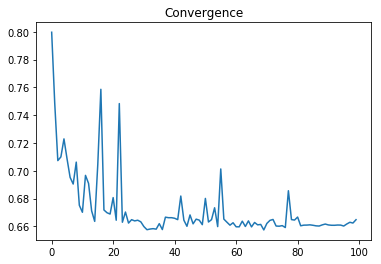

In [0]:
#next_batch
def next_batch(x1,x2,y,seq_len,start,batch_size):
     return x1[start:start + batch_size],x2[start:start + batch_size], y[start:start + batch_size],seq_len[start:start + batch_size]
                                  
#Network Parameters
n_classes = 512
n_channels = 1
hidden_units = 512

#Defining hyperparameters
batch_size = 90
n_epoch = 100
display_f = 10
keep_prob = 0.9
learning_rate = 0.0001
dropout = 0.1

#Calc number of iterations in each epoch
n_iter = len(x1_train)//batch_size


#GRU CELL
def lstm_cell():
    lstm =tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.GRUCell(hidden_units, 
                                                          kernel_initializer =tf.contrib.layers.variance_scaling_initializer()),
                                                          output_keep_prob = 1 - dropout)
    return lstm

#Batch Normaliztion
def bn_layer(x,train_phase,momentum=0.9,epsilon=0.001):
  return tf.layers.batch_normalization(
        inputs=x,
        axis=-1,
        momentum=momentum,
        epsilon=epsilon,
        center=True,
        scale=True,
        reuse= False,
        training = train_phase)

  
#Construct the graph
tf.reset_default_graph()
x1 = tf.placeholder(tf.float32,[None,None,513])
x2 = tf.placeholder(tf.float32,[None,None,513])
y = tf.placeholder(tf.float32,[None,1])
seq_len = tf.placeholder(tf.int32,None)
flag_training=tf.placeholder(tf.bool)



#Network function
def siamese_model(x,flag_training):
    with tf.name_scope("model"):
#         with tf.variable_scope("conv1",reuse = tf.AUTO_REUSE ) as scope:
#               net = tf.layers.conv2d(input, 32, [3, 3], activation=tf.nn.relu, padding='SAME',
#                     kernel_initializer=tf.contrib.layers.variance_scaling_initializer())
#               net = tf.layers.max_pooling2d(net,  pool_size=[2,2],padding='same', strides=[2,2])

#         with tf.variable_scope("conv2",reuse = tf.AUTO_REUSE ) as scope:
#               net = tf.layers.conv2d(input, 32, [3, 3], activation=tf.nn.relu, padding='SAME',
#                     kernel_initializer=tf.contrib.layers.variance_scaling_initializer())
#               net = tf.layers.max_pooling2d(net,  pool_size=[2,2],padding='same', strides=[2,2])

        with tf.variable_scope("rnn1",reuse = tf.AUTO_REUSE ) as scope:
              cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(2)])
              net, _  = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32,sequence_length=seq_len)


        with tf.variable_scope("dense",reuse = tf.AUTO_REUSE ) as scope: 
              net = bn_layer(net,flag_training)
              net = tf.layers.dense(net, n_classes, kernel_initializer= tf.contrib.layers.variance_scaling_initializer(),activation=tf.nn.tanh)
        net = tf.layers.flatten(net)
        return net

#Normalize the layeroutputs for cosine similiarity
x1_output =  tf.nn.l2_normalize(siamese_model(x1,flag_training),0)
x2_output =  tf.nn.l2_normalize(siamese_model(x2,flag_training),0)

#Dot product of the embedding
layer_dot = tf.reduce_sum(tf.multiply( x1_output, x2_output ),1, keep_dims=True)
#Sigmoid wrapper
sig_layer = tf.sigmoid(layer_dot)

# loss_pos = -tf.multiply(y,tf.log(sig_layer))
# loss_neg = - tf.multiply(tf.subtract(1.0,y),tf.log(tf.subtract(1.0,sig_layer)))
# loss = tf.reduce_mean(tf.add(loss_pos,loss_neg))
#Cross extropy loss
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=sig_layer))
train_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(sig_layer),y),tf.float32))

#Saving the session
saver = tf.train.Saver()

#Running the session
with tf.Session()  as sess:
  err = np.zeros(n_epoch)
  tf.global_variables_initializer().run() 
  tf.local_variables_initializer().run()
  train_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)
  extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  for epoch in range(n_epoch):

    
    for itr in range(n_iter):
      
      
      x1_batch,x2_batch,y_batch,seq_len_batch = next_batch(x1_train,x2_train,y_train,x1_train_len,itr*batch_size,batch_size)
#       x1_batch = x1_batch.reshape([batch_size,x1_train.shape[1],x1_train.shape[2],n_channels])
#       x2_batch = x2_batch.reshape([batch_size,x2_train.shape[1],x2_train.shape[2],n_channels])
      y_batch = y_batch.reshape([batch_size,1])

                             
#       x1_out,x2_out = sess.run([x1_output,x2_output], feed_dict={x1:x1_batch,x2:x2_batch,y:y_batch,seq_len:seq_len_batch})
#       print(x1_out.shape,x2_out.shape)

      _,_,tr_loss,sig_layer1 = sess.run([train_optimizer,extra_update_ops,loss,x1_output], feed_dict={x1:x1_batch,x2:x2_batch,y:y_batch,seq_len:seq_len_batch,flag_training:True})
      #print(itr,tr_loss,sig_layer1)
#       print(out,out.shape)
#       print(itr)
    
    #Storing error and Accuracy
    err[epoch],acc = sess.run([loss,accuracy],\
                              feed_dict={x1:x1_test,
                                         x2:x2_test,
                                         y:y_test.reshape([len(y_test),1]),seq_len:x1_test_len,flag_training:False})
    
    #Saving model to a file to be used for scoring
    saver.save(sess, "Model_1")
    
    #Pring the Loss and SNR for each epoch
    if epoch%display_f == 0:      
      print("Epoch", str(epoch), "\t| Test Loss =", str(round(err[epoch],3)), "\t| Test Accuracy =", str(round(acc,2)))
    
#plotting convergence    
plt.figure()
plt.plot(err)
plt.title('Convergence')  

**The test accuracy is 74% on the 1800 pairs. 900 positive and 900 negative examples are in the data.**

In [0]:
#Question 2
#Load data

path ='/content/gdrive/My Drive/Assignment_4/'
f = open(path + 'hw4_tr7.pkl','rb') 
train = pickle.load(f)


f = open(path + 'hw4_te7.pkl','rb') 
test = pickle.load(f)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use tf.cast instead.
Epoch 0 	| Test Loss = 90.95


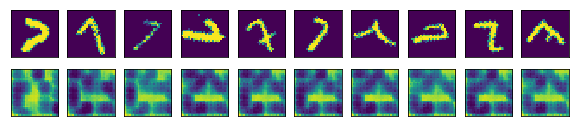

Epoch 100 	| Test Loss = 36.13


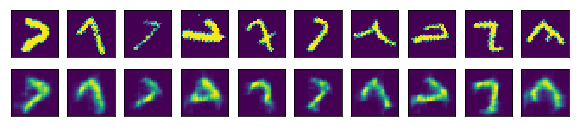

Epoch 200 	| Test Loss = 32.95


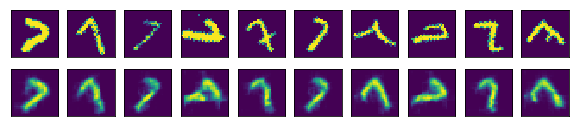

Epoch 300 	| Test Loss = 32.13


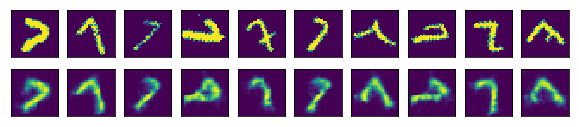

Epoch 400 	| Test Loss = 31.53


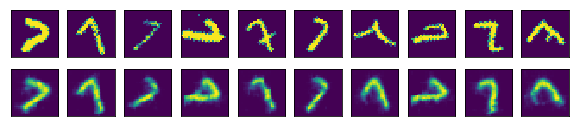

Epoch 500 	| Test Loss = 31.09


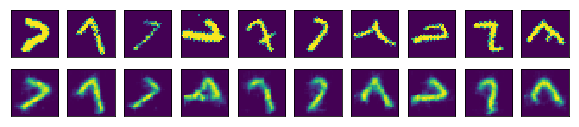

Epoch 600 	| Test Loss = 30.81


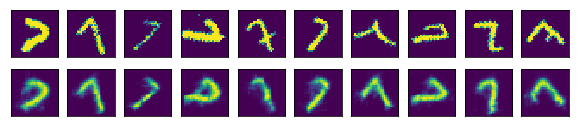

Epoch 700 	| Test Loss = 30.63


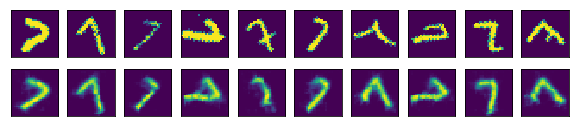

Epoch 800 	| Test Loss = 30.31


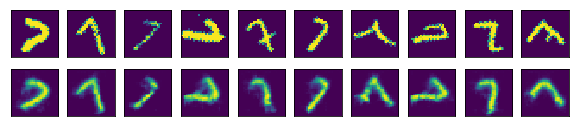

Epoch 900 	| Test Loss = 30.27


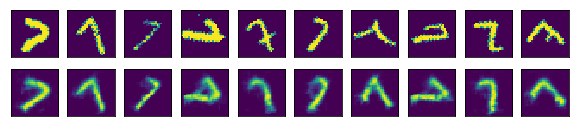

Text(0.5, 1.0, 'Convergence')

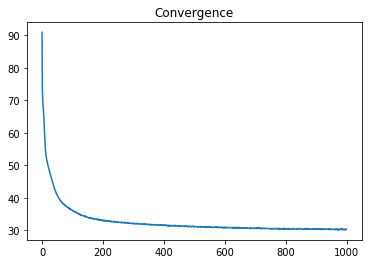

In [0]:
#next_batch
def next_batch(x,start,batch_size):
    return x[start:start + batch_size]
                                  
#Network Parameters
latent_units = 4

#Defining hyperparamters
batch_size = 32
n_epoch = 1000
display_f = 100
learning_rate = 0.0001
dropout = 0.1

#Calc number of iterations in each epoch
n_iter = len(train)//batch_size
                                  
#leaky relu fnction
def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.1)

  
#Creating the graph
tf.reset_default_graph()
x_img = tf.placeholder(tf.float32,[None,28,28])
x_img_flat = tf.reshape(x_img, shape=[-1, 28 * 28])



#Encoder
def encoder_vae(x,dropout,latent_units,batch_size):
    with tf.variable_scope("encoder", reuse=None):
        x = tf.reshape(x,[-1,28,28,1])
        x = tf.layers.conv2d(x, filters=32, kernel_size=3, strides=2, padding='same', activation=leaky_relu,kernel_initializer= tf.contrib.layers.variance_scaling_initializer())
        x = tf.layers.dropout(x, dropout)
        x = tf.layers.conv2d(x, filters=32, kernel_size=3, strides=1, padding='same', activation=leaky_relu,kernel_initializer= tf.contrib.layers.variance_scaling_initializer())
        x = tf.layers.dropout(x, dropout)
        x = tf.layers.conv2d(x, filters=32, kernel_size=3, strides=1, padding='same', activation=leaky_relu,kernel_initializer= tf.contrib.layers.variance_scaling_initializer())
        x = tf.layers.dropout(x, dropout)
        x = tf.layers.flatten(x)
        mu = tf.layers.dense(x, latent_units, kernel_initializer= tf.contrib.layers.variance_scaling_initializer())
        sd = tf.layers.dense(x, latent_units, kernel_initializer= tf.contrib.layers.variance_scaling_initializer(), activation=tf.nn.softplus)
        eps = tf.random_normal([tf.shape(x)[0],latent_units])
        z  = mu + eps*sd
    return z,mu,sd

#Decoder
def decoder_vae(x, dropout):
    with tf.variable_scope("decoder", reuse=None):
      x = tf.layers.dense(x, 49,activation=leaky_relu, kernel_initializer= tf.contrib.layers.variance_scaling_initializer())
      x = tf.reshape(x,[-1,7,7,1])
      x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu,kernel_initializer= tf.contrib.layers.variance_scaling_initializer())
      x = tf.layers.dropout(x, dropout)
      x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu,kernel_initializer= tf.contrib.layers.variance_scaling_initializer())
      x = tf.layers.dropout(x, dropout)
      x = tf.layers.conv2d(x, filters=1, kernel_size=3, strides=1, padding='same', activation=tf.sigmoid,kernel_initializer= tf.contrib.layers.variance_scaling_initializer())
      img = tf.reshape(x, shape=[-1, 28, 28])
      return img
   
  
#set the outputs
sample,mean,sd = encoder_vae(x_img,dropout,latent_units,batch_size)
recons_image = decoder_vae(sample,dropout)

#Loss
recon_img_flat = tf.reshape(recons_image, shape=[-1, 28 * 28])
recons_loss = tf.reduce_sum(tf.squared_difference(recon_img_flat, x_img_flat), 1)
kl_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * tf.log(sd) - tf.square(mean) - tf.square(sd), 1)
loss = tf.reduce_mean(recons_loss + kl_loss)
train_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)         
         

saver = tf.train.Saver()

with tf.Session()  as sess:
  tf.global_variables_initializer().run()
  err = np.zeros(n_epoch)
  for epoch in range(n_epoch):
   # print('Epoch ', str(epoch))
#     print('_'*30)
    
    for itr in range(n_iter):
      
      
      x_batch = next_batch(train,itr*batch_size,batch_size)

      sess.run(train_optimizer, feed_dict={x_img:x_batch})
      
#       if itr%display_f == 0:
#         batch_loss, batch_accuracy = sess.run([loss,accuracy],feed_dict={x:x_batch,y:y_batch})
        
#         print("Iteration", str(itr), "\t| Batch Loss =", str(round(batch_loss,2)), "\t| Batch Accuracy =", str(round(batch_accuracy,2)))
    #Validation after each epoch
#     valid_loss, valid_accuracy = sess.run([loss,accuracy],feed_dict={x:x_valid,y:y_valid})
#     print('_'*30)      
#     print("Epoch", str(epoch), "\t| Validation Loss =", str(round(valid_loss,2)), "\t| Validation Accuracy =", str(round(valid_accuracy,2)))
#     print('_'*30)

    #Test loss and accuracy
    err[epoch],img = sess.run([loss,recons_image],feed_dict={x_img:test})
    
    
    saver.save(sess, "Model_2")
    if epoch%display_f == 0:
      print("Epoch", str(epoch), "\t| Test Loss =", str(round(err[epoch],2)))
      np.random.seed(1234) 
      idx = np.random.randint(0,len(test),10)
      orig_image = [test[i] for i in idx]
      img = [img[i] for i in idx]

      #Plotting and seeing the output images
      fig=plt.figure(figsize=(10, 2))
      

      for i in range(1, 21):
          if i <11:
            img_1 = orig_image[i-1]
          else: 
            img_1 = img[i-11]
          fig.add_subplot(2, 10, i)          
          plt.imshow(img_1)
          plt.xticks([])
          plt.yticks([])
      plt.show()

      
plt.figure()
plt.plot(err)
plt.title('Convergence')    



INFO:tensorflow:Restoring parameters from Model_2


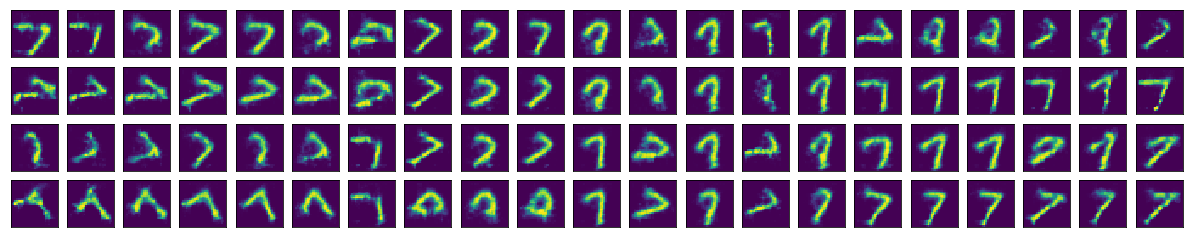

In [0]:
#Generating examples for each dimension
X = np.array([np.random.normal(0, 1, latent_units-1) for _ in range(21)])
Y = np.array([i/10 for i in range(-30,31,3)])
Z_1 = np.hstack((Y.reshape(21,1),X))
Z_2 = Z_1[:, [1, 0, 2, 3]]
Z_3 = Z_1[:, [1, 2, 0, 3]]
Z_4 = Z_1[:, [1, 2, 3, 0]]

Z = np.vstack((Z_1,Z_2,Z_3,Z_4))

#Restoring the model and reconstructing the images
with tf.Session() as sess:
  saver.restore(sess, "Model_2")
  out_img  = sess.run(recons_image,{sample:Z})
  
  

#Plotting the output images for different dimensions
fig=plt.figure(figsize=(21, 4))
for i in range(1, 85):
    img_1 = out_img[i-1]        
    fig.add_subplot(4, 21, i)          
    plt.imshow(img_1)
    plt.xticks([])
    plt.yticks([])
plt.show()



Second dimension shows the effect of anti clockwise rotation whereas the fourth dimension shows the effect of clockwise rotation.